In [1]:
import os
import pickle
import re

import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from geopy.distance import geodesic

In [2]:
locations_list = [
    [55.539306, 051.856451],    # д. Клятле
    [55.622944, 051.825578],    # ул. Ахтубинская, 4б
    [55.650091, 051.852687],    # ул. Гагарина, 32
    [55.598983, 051.771936],    # ул. Юбилейная, 3
    [55.613193, 051.784821],    # ул. Южная, 3
    [55.654578, 051.800072]     # ул. Ямьле, 20
]

### Промышленные объекты и их координаты  
https://fabricators.ru/zavody/nizhnekamsk  
https://xn--80aegj1b5e.xn--p1ai/factories/nizhnekamsk

In [3]:
plants_list = [
    [55.577916, 51.829092],    # Камский завод полимерных материалов
    [55.580406, 51.832423],    # Нижнекамский завод металлических конструкций
    [55.600826, 52.006558],    # Нижнекамсктехуглерод
    [55.611971, 51.949400],    # Нижнекамскнефтехим (завод Этилен)
    [55.607269, 51.918995],    # Промзона 1_1
    [55.596030, 51.916050],    # Промзона 1_2
    [55.608176, 51.950205],    # Промзона 2_1
    [55.594242, 51.953988],    # Промзона 2_2
    [55.611434, 51.968755],    # Нижнекамскшина (массовые шины)
    [55.611325, 51.984527],    # Нижнекамскшина (грузовые шины)
    [55.568804, 51.887739],    # Таиф-НК, завод бензинов
    [55.590493, 51.943682],    # Таиф-НК, комплекс глубокой переработки нефти
    [55.595089, 51.808537],    # Камасталь
    [55.567365, 51.909208],    # Танеко
    [55.604712, 51.963051],    # Завод Эластик
    [55.602338, 51.808578],    # Криоген-НК
    [55.602188, 51.844907],    # Камэнергостройпром
  # [55.612118, 51.975523],    # Нижнекамский механический завод
    ]
plants_dict = {
    "Камский завод полимерных материалов": [55.577916, 51.829092],
    "Нижнекамский завод металлических конструкций": [55.580406, 51.832423],
    "Нижнекамсктехуглерод": [55.600826, 52.006558],
    "Нижнекамскнефтехим (завод Этилен)": [55.611971, 51.949400],
    "Промзона 1_1": [55.607269, 51.918995],
    "Промзона 1_2": [55.596030, 51.916050],
    "Промзона 2_1": [55.608176, 51.950205],
    "Промзона 2_2": [55.594242, 51.953988],
    "Нижнекамскшина (массовые шины)": [55.611434, 51.968755],
    "Нижнекамскшина (грузовые шины)": [55.611325, 51.984527],
    "Таиф-НК, завод бензинов": [55.568804, 51.887739],
    "Таиф-НК, комплекс глубокой переработки нефти": [55.590493, 51.943682],
    "Камасталь": [55.595089, 51.808537],
    "Танеко": [55.567365, 51.909208],
    "Завод Эластик": [55.604712, 51.963051],
    "Криоген-НК": [55.602338, 51.808578],
    "Камэнергостройпром": [55.602188, 51.844907]
}

### Карта производств

In [83]:
plants_map = folium.Map(location=[55.596030, 51.916050], zoom_start = 11.5)

# Добавление маркеров
for coordinates in plants_list:
    folium.Circle(
        radius=40,
        location=coordinates,
        # popup = marker,
        color='gray',
        fill=True,
        fill_opacity=1
    ).add_to(plants_map)

plants_map.save("../app/templates/plants_map.html")

## Инференс  
по данным, на которых обучались модели

In [5]:
# Функция для преобразования формата скорости ветра
def extract_value(value):
    if isinstance(value, (int, float)):
        return value
    match = re.search(r'\((\d+\.\d+)\)', str(value))
    if match:
        return float(match.group(1))
    return value


# Функция загрузки и подготовки данных по нужным веществам из всех 6 геоточек
def load_data(file, all_substances, meteo_params):
    """file - файл с данными для определенной геоточки
       all_substances - названия загрязняющих веществ
    """

    point = pd.read_excel(os.path.join(path, file))
    indexes = list(point.loc[0])
    indexes = indexes[1:]
    point = point.loc[3:].set_index('Интервал отбора')
    point.columns = indexes

    point = point.apply(lambda x: x.str.replace(',', '.'))
    point['V ветра, м/с'] = point['V ветра, м/с'].apply(extract_value)
    point[['Угол ветра, °', 'Направление ветра']] = point['D ветра, °'].str.extract(r'(\d+)\s?\((.+)\)')
    point['Направление ветра'].replace(np.NaN, 'Ш', inplace=True)

    # Пересечение множеств названий столбцов и substances
    substances = set(indexes) & set(all_substances)
    columns = [*substances, *meteo_params]
    point = point[columns]

    # Заполнение пропусков, если их в столбце не более 5%
    for col in point.columns:
        point[col] = pd.to_numeric(point[col], errors='ignore')
        if point[col].isna().sum().sum() / len(point) < 0.05:
            point[col].interpolate(inplace=True)

    return point

def melt_columns(df, substances, Mr, meteo_params):
    """Функция 'расплавления' столбцов с веществами"""

    df = pd.melt(df, id_vars=meteo_params, ignore_index=False)

    # Закодируем названия веществ их молекулярной массой
    df.replace(substances, Mr, inplace=True)
    df.rename(columns={"variable": "Mr", "value": "C, мг/м³"}, inplace=True)

    df["Mr"] = pd.to_numeric(df["Mr"], errors='coerce')

    return df

In [6]:
meteo_params = ['T внеш., °C',
                'P атм., мм.рт.ст.',
                'V ветра, м/с',
                'Угол ветра, °',
                'Направление ветра'
                ]
# Загрязнители в алфавитном порядке
substances = ['CO, мг/м³',
              'H2S, мг/м³',
              'NH3, мг/м³',
              'NO, мг/м³',
              'NO2, мг/м³',
              'SO2, мг/м³'
              ]
# Молекулярные массы веществ из substances
Mr = [28, 30, 46, 17, 64, 34]

# Временной лаг
lags = 4

In [7]:
# Директория с данными
path = '../data/raw'
files = os.listdir(path)
os.listdir(path)

['test',
 'Усредненные_данные_Нижнекамск_т.1.xlsx',
 'Усредненные_данные_Нижнекамск_т.2.xlsx',
 'Усредненные_данные_Нижнекамск_т.3.xlsx',
 'Усредненные_данные_Нижнекамск_т.4.xlsx',
 'Усредненные_данные_Нижнекамск_т.5.xlsx',
 'Усредненные_данные_Нижнекамск_т.6.xlsx']

### Загрузка и обработка входных данных  
Проверим вычисление концентраций для одного из контрольных пунктов. Подадим в модель часть данных из д. Клятле, в которые произошел выброс SO2.

In [8]:
points = [load_data(file, substances, meteo_params) for file in files if file.endswith('.xlsx')]
points[0].head()    # д. Клятле

,"CO, мг/м³","NO2, мг/м³","SO2, мг/м³","H2S, мг/м³","NO, мг/м³","NH3, мг/м³","T внеш., °C","P атм., мм.рт.ст.","V ветра, м/с","Угол ветра, °",Направление ветра
Интервал отбора,,,,,,,,,,,
01.06.2023 00:00,0.2,0.001,0.003,0.0004,0.001,0.014,16.8,745.1,0.2,106.0,В
01.06.2023 00:30,0.2,0.001,0.003,0.0004,0.002,0.014,15.8,745.1,0.3,106.0,В
01.06.2023 01:00,0.2,0.002,0.002,0.0006,0.002,0.014,15.3,745.0,0.1,107.0,В
01.06.2023 01:30,0.2,0.001,0.003,0.0005,0.002,0.014,14.8,745.1,0.0,NaN,Ш
01.06.2023 02:00,0.2,0.001,0.003,0.0005,0.002,0.015,15.2,745.2,0.4,134.0,Ю-В


In [9]:
df_melted_list = [melt_columns(df, substances, Mr, meteo_params) for df in points]

In [10]:
df_melted_list[0].head()

,"T внеш., °C","P атм., мм.рт.ст.","V ветра, м/с","Угол ветра, °",Направление ветра,Mr,"C, мг/м³"
Интервал отбора,,,,,,,
01.06.2023 00:00,16.8,745.1,0.2,106.0,В,28,0.2
01.06.2023 00:30,15.8,745.1,0.3,106.0,В,28,0.2
01.06.2023 01:00,15.3,745.0,0.1,107.0,В,28,0.2
01.06.2023 01:30,14.8,745.1,0.0,NaN,Ш,28,0.2
01.06.2023 02:00,15.2,745.2,0.4,134.0,Ю-В,28,0.2


In [11]:
# ничего не менялось
def make_df(df, num, target_num, lags=None):
    """Функция предобработки датасета с предикторами
       num - номер геоточки
       target_num - номер точки, в которой модель будет считать концентрацию
    """

    coor = locations_list[num - 1]
    target_coor = locations_list[target_num - 1]

    df = df.copy()
    df.dropna(inplace=True)
    df['lat'], df['lon'] = coor

    # Добавим расстояние от данной точки до точки c target_coor в качестве входной переменной
    df['distance, km'] = geodesic(coor, target_coor).km

    # Фичи c временными лагам
    if lags:
        for i in range(1, lags):
            df[f"T внеш_{i}"] = df['T внеш., °C'].shift(i)
            df[f"P атм._{i}"] = df['P атм., мм.рт.ст.'].shift(i)
            df[f"V ветра_{i}"] = df['V ветра, м/с'].shift(i)
            df[f"Угол ветра_{i}"] = df['Угол ветра, °'].shift(i)
            df[f"C, мг/м³_{i}"] = df['C, мг/м³'].shift(i)
    df.dropna(inplace=True)

    return df

# переименована переменная target_num
def concat_dfs(df_melted_list, target_num, lags=5):
    X_list = [make_df(df, i + 1, target_num, lags) for i, df in enumerate(df_melted_list)]
    del X_list[target_num - 1]  # сопоставление точки самой с собой
    X_num = pd.concat(X_list, axis=0)
    return X_num

In [12]:
# Вычисляем расстояния из всех контрольных пунктов до выбранной точки (т.1, Клятле)
X = concat_dfs(df_melted_list, 1, lags)
X.dropna(inplace=True)
X = pd.get_dummies(X, columns=['Направление ветра'])

In [13]:
# Рассчитаем прогноз только для SO2
for substance in ['SO2, мг/м³']:
    catboost = pickle.load(open(f'../app/ml_models/model_{substance[:3]}.pkl', 'rb'))
    pred = catboost.predict(X)
    print((pred < 0).sum(), 'отрицательных значений заменены на 0')
    pred[pred < 0] = 0

    # Отсортируем значения по времени
    pred = pd.Series(pred, index=X.index)
    pred_sorted = pred.sort_index()

841 отрицательных значений заменены на 0


In [14]:
# Отберем значения для графика
pred_plot = pred_sorted[500:2700]
# Реальные значения по SO2
real = points[0][substance]
real_plot = real.loc[real.index.isin(pred_plot.index)]

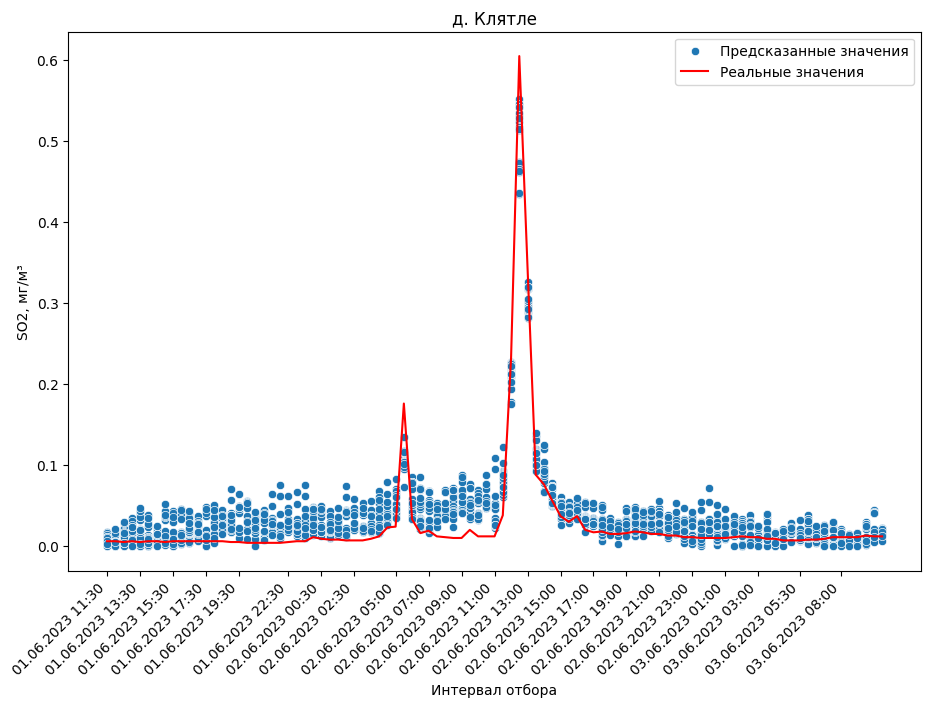

In [15]:
plt.figure(figsize=(11, 7))
ax = sns.scatterplot(data=pred_plot, label='Предсказанные значения')
real_plot.plot(ax=ax, label='Реальные значения', color='red')
x_labels = pred_plot.index
ax.set_xticks(x_labels[::100])
ax.set_xticklabels(x_labels[::100], rotation=45, ha="right")
ax.set_ylabel(substance)
plt.title('д. Клятле')
plt.legend()
plt.show()

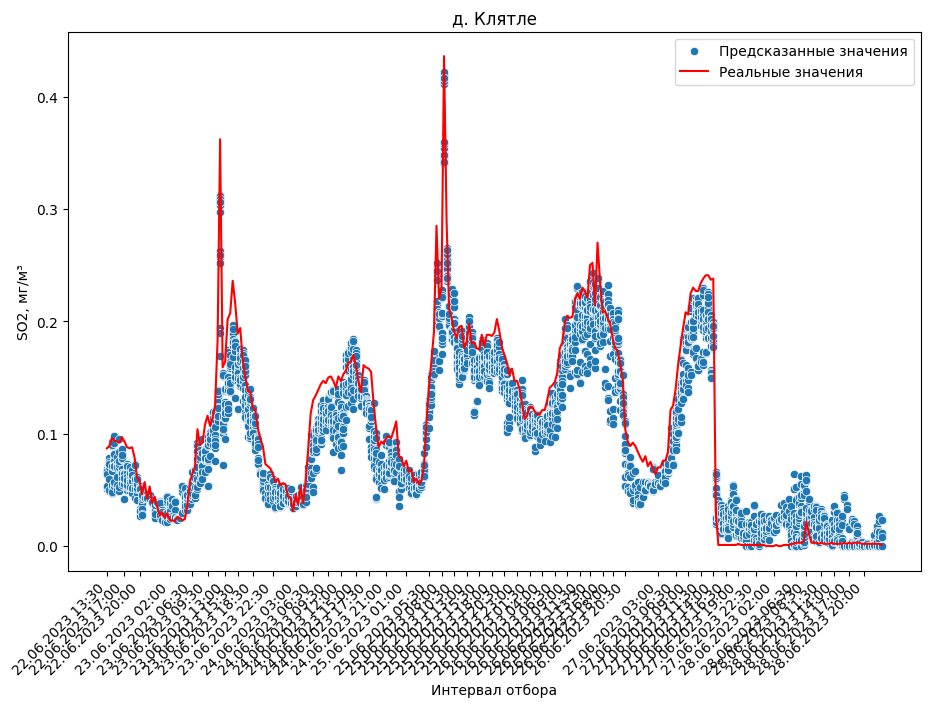

In [16]:
# Отберем значения для графика
pred_plot = pred_sorted[20000:25000]
real = points[0][substance]
real_plot = real.loc[real.index.isin(pred_plot.index)]

plt.figure(figsize=(11, 7))
ax = sns.scatterplot(data=pred_plot, label='Предсказанные значения')
real_plot.plot(ax=ax, label='Реальные значения', color='red')
x_labels = pred_plot.index
ax.set_xticks(x_labels[::100])
ax.set_xticklabels(x_labels[::100], rotation=45, ha="right")
ax.set_ylabel(substance)
plt.title('д. Клятле')
plt.legend()
plt.show()

Сейчас одному моменту времени соответствует несколько предсказанных значений, так как прогнозы делаются по данным из нескольких мест и на основании уровня различных веществ в этих местах. Поскольку для нас важно не пропустить появление повышенных концентраций, выберем для одного индекса времени только максимальное предсказанное значение.

In [30]:
# Максимальные из предсказанных значений
max_pred = pred_sorted.groupby(level=0).max()

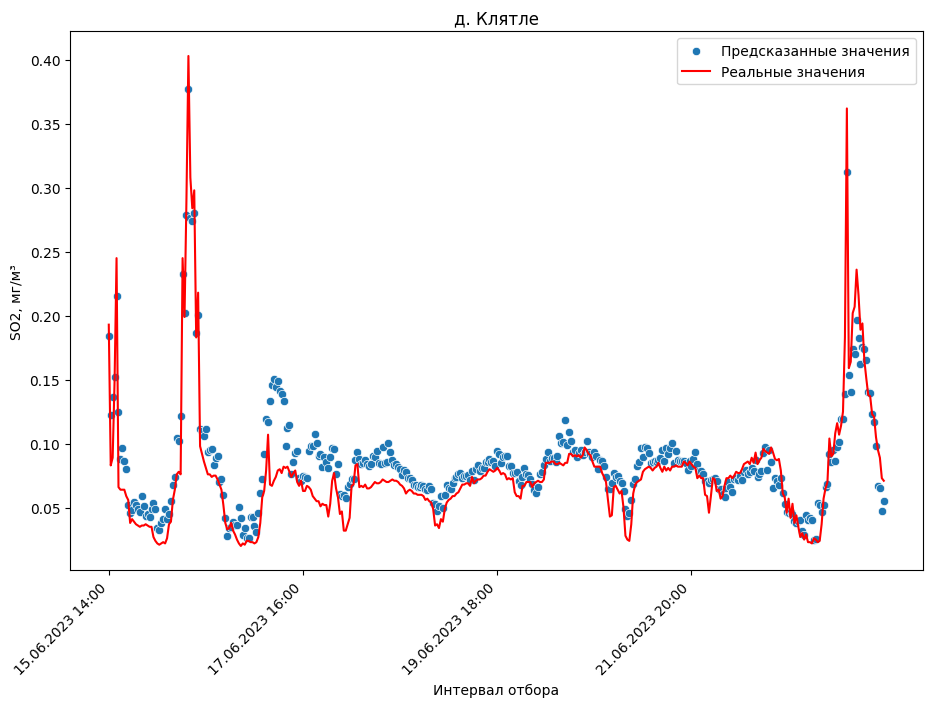

In [55]:
from sklearn.metrics import mean_absolute_error
print('MAE =', mean_absolute_error(max_pred, real))

MAE = 0.01746355098660505


Отладим вычисление концентраций для одной из точек с предприятием на примере **Промзоны 1_1**

In [56]:
target_location = plants_list[4]
print('Координаты Промзоны 1_1')
target_location

Координаты Промзоны 1_1


[55.607269, 51.918995]

In [57]:
points = [load_data(file, substances, meteo_params) for file in files if file.endswith('.xlsx')]
df_melted_list = [melt_columns(df, substances, Mr, meteo_params) for df in points]

In [58]:
def make_df(df, num, target_num, lags=None):
    """Функция предобработки датасета с предикторами
       num - номер геоточки
       target_num - номер точки, в которой модель будет считать концентрацию
    """

    coor = locations_list[num - 1]
    target_coor = plants_list[target_num - 1]   # изменился список координат
    
    df = df.copy()
    df.dropna(inplace=True)
    df['lat'], df['lon'] = coor

    # Добавим расстояние от данной точки до точки c target_coor в качестве входной переменной
    df['distance, km'] = geodesic(coor, target_coor).km

    # Фичи c временными лагам
    if lags:
        for i in range(1, lags):
            df[f"T внеш_{i}"] = df['T внеш., °C'].shift(i)
            df[f"P атм._{i}"] = df['P атм., мм.рт.ст.'].shift(i)
            df[f"V ветра_{i}"] = df['V ветра, м/с'].shift(i)
            df[f"Угол ветра_{i}"] = df['Угол ветра, °'].shift(i)
            df[f"C, мг/м³_{i}"] = df['C, мг/м³'].shift(i)
    df.dropna(inplace=True)

    return df

In [59]:
def concat_dfs(df_melted_list, target_num, lags=5):
    X_list = [make_df(df, i + 1, target_num, lags) for i, df in enumerate(df_melted_list)]
    # del X_list[target_num - 1]  # сопоставление точки самой с собой
    X_num = pd.concat(X_list, axis=0)
    return X_num

In [60]:
# Вычисляем расстояния из всех контрольных пунктов до предприятия
X = concat_dfs(df_melted_list, 4 + 1, lags)
X.dropna(inplace=True)
X = pd.get_dummies(X, columns=['Направление ветра'])
X.head()

,"T внеш., °C","P атм., мм.рт.ст.","V ветра, м/с","Угол ветра, °",Mr,"C, мг/м³",lat,lon,"distance, km",T внеш_1,...,"C, мг/м³_3",Направление ветра_В,Направление ветра_З,Направление ветра_С,Направление ветра_С-В,Направление ветра_С-З,Направление ветра_Ш,Направление ветра_Ю,Направление ветра_Ю-В,Направление ветра_Ю-З
Интервал отбора,,,,,,,,,,,,,,,,,,,,,
01.06.2023 02:00,15.2,745.2,0.4,134.0,28,0.2,55.539306,51.856451,8.533335,15.3,...,0.2,False,False,False,False,False,False,False,True,False
01.06.2023 02:30,16.4,745.1,0.9,157.0,28,0.2,55.539306,51.856451,8.533335,15.2,...,0.2,False,False,False,False,False,False,False,True,False
01.06.2023 03:00,17.0,745.1,2.1,163.0,28,0.2,55.539306,51.856451,8.533335,16.4,...,0.2,False,False,False,False,False,False,True,False,False
01.06.2023 03:30,17.4,745.4,2.3,206.0,28,0.2,55.539306,51.856451,8.533335,17.0,...,0.2,False,False,False,False,False,False,False,False,True
01.06.2023 04:00,17.6,745.5,2.3,229.0,28,0.2,55.539306,51.856451,8.533335,17.4,...,0.2,False,False,False,False,False,False,False,False,True


In [61]:
# Загрузка моделей для определения каждого вещества
for substance in substances:
    print(f'../app/ml_models/model_{substance[:3]}.pkl')

../app/ml_models/model_CO,.pkl
../app/ml_models/model_H2S.pkl
../app/ml_models/model_NH3.pkl
../app/ml_models/model_NO,.pkl
../app/ml_models/model_NO2.pkl
../app/ml_models/model_SO2.pkl


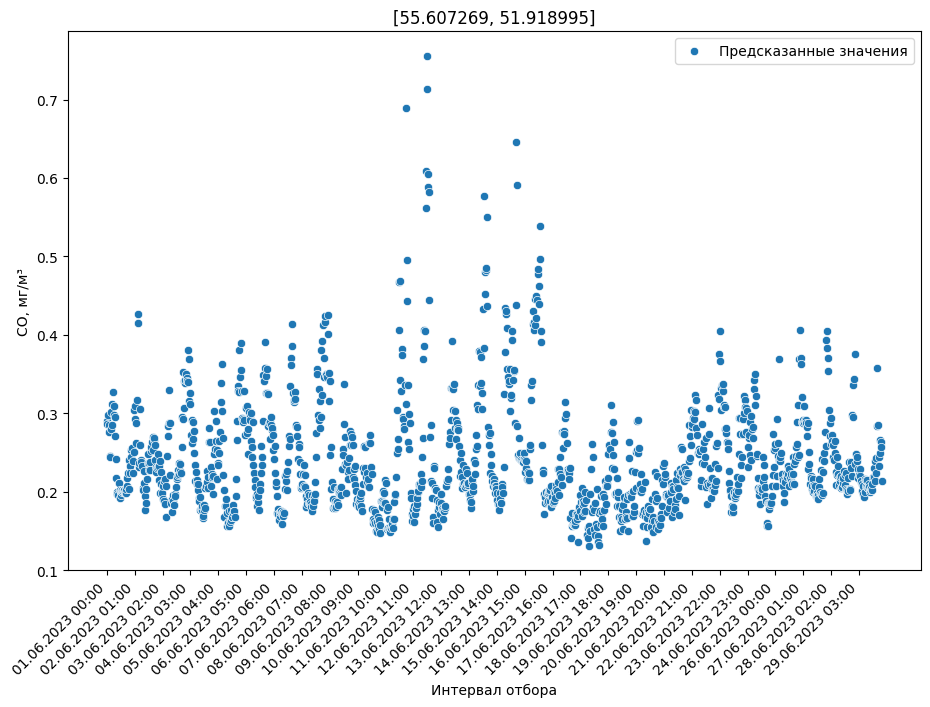

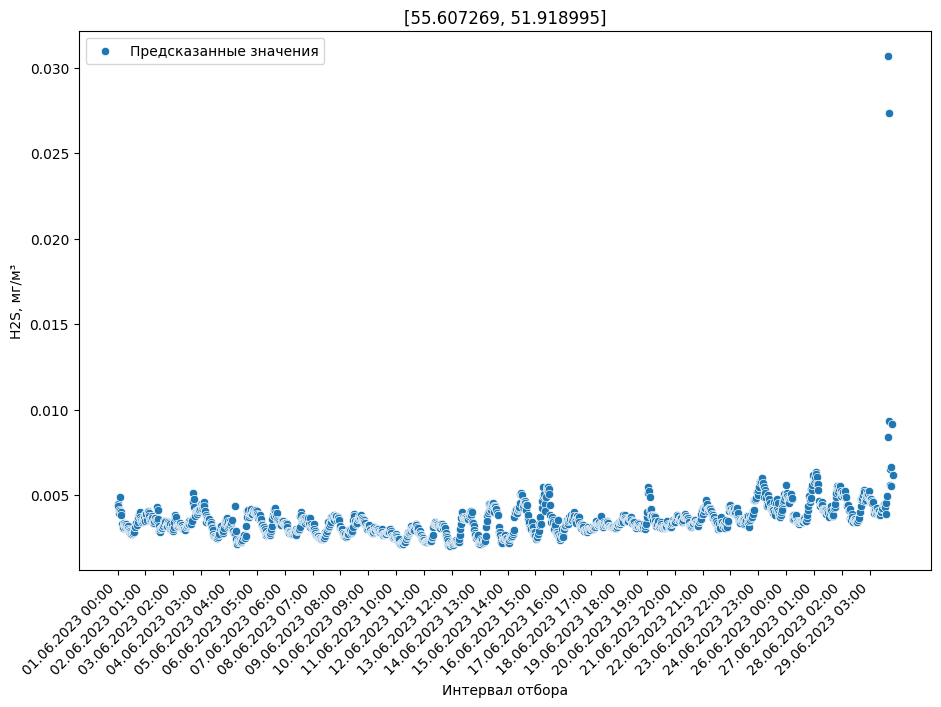

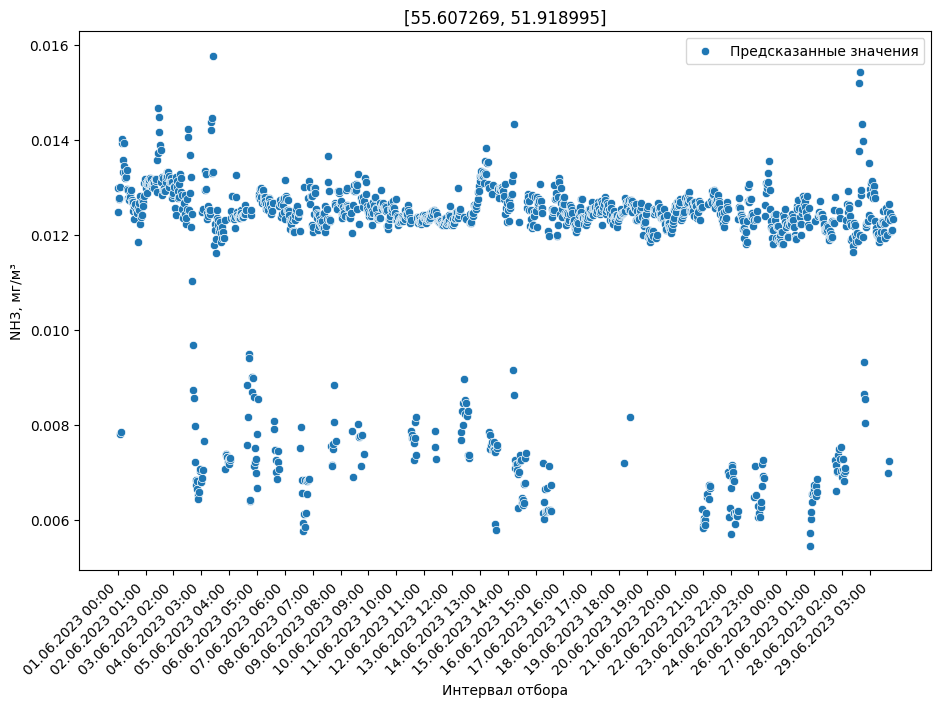

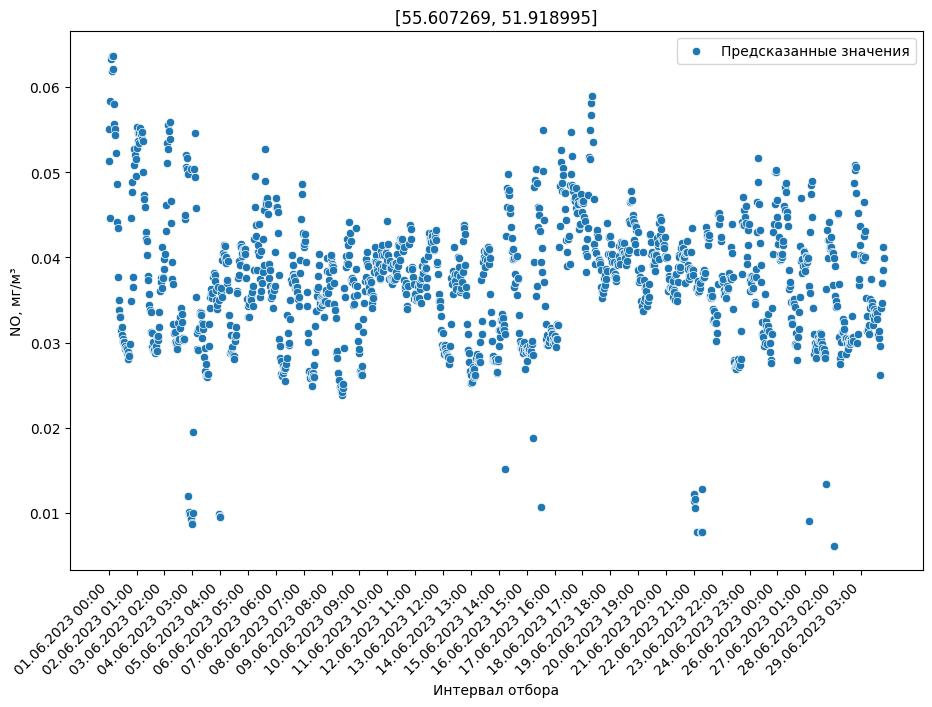

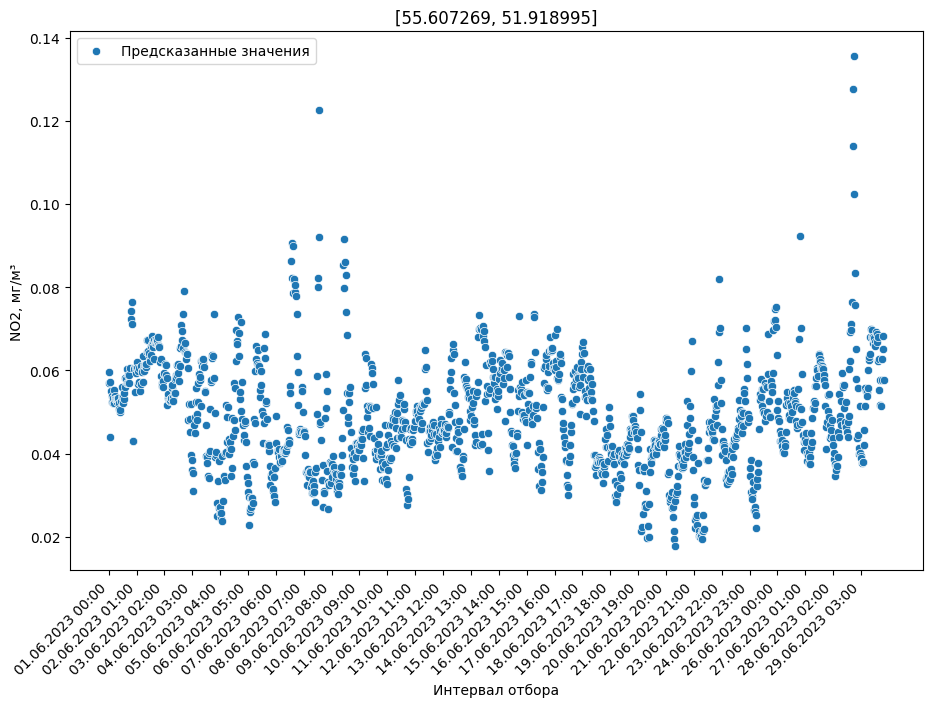

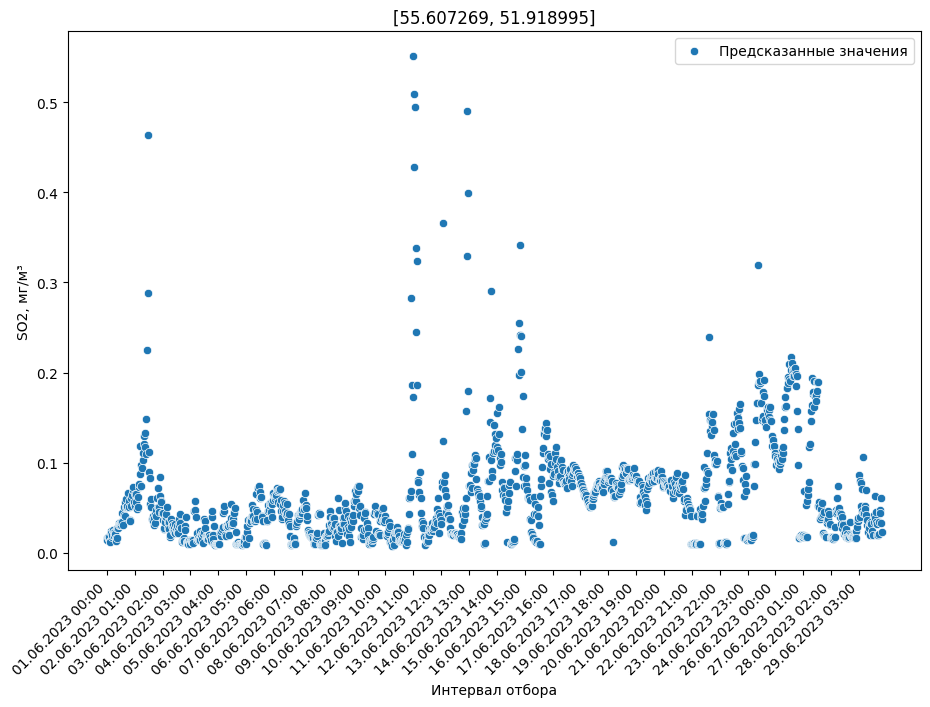

In [64]:
for substance in substances:

    catboost = pickle.load(open(f'../app/ml_models/model_{substance[:3]}.pkl', 'rb'))
    pred = catboost.predict(X)
    
    # Замена отрицательных значений
    pred[pred < 0] = 0
    # Сортировка значений по времени
    pred = pd.Series(pred, index=X.index)
    pred_sorted = pred.sort_index()
    # Максимальные из предсказанных значений
    max_pred = pred_sorted.groupby(level=0).max()
    
    # График
    plt.figure(figsize=(11, 7))
    ax = sns.scatterplot(data=max_pred, label='Предсказанные значения')
    x_labels = max_pred.index
    ax.set_xticks(x_labels[::50])
    ax.set_xticklabels(x_labels[::50], rotation=45, ha="right")
    ax.set_ylabel(substance)
    plt.title(target_location)
    plt.legend()
    plt.show()
    print()

### Визуализация на карте

Выведем уровни ПДК

In [71]:
point1 = pd.read_excel('../data/raw/Усредненные_данные_Нижнекамск_т.1.xlsx')
threshold = dict(zip(point1.iloc[0, 2:].values, point1.iloc[0:2, 2:].iloc[1].values))
threshold

{'CO, мг/м³': 5,
 'NO, мг/м³': 0.4,
 'NO2, мг/м³': 0.2,
 'NH3, мг/м³': 0.2,
 'SO2, мг/м³': 0.5,
 'H2S, мг/м³': 0.008,
 'T внеш., °C': '-',
 'V ветра, м/с': '-',
 'D ветра, °': '-',
 'H внеш., %': '-',
 'P атм., мм.рт.ст.': '-',
 'R осадк., мм/ч': '-'}

In [72]:
max_pred.head()

Интервал отбора
01.06.2023 00:00    0.015937
01.06.2023 00:30    0.014119
01.06.2023 01:00    0.017914
01.06.2023 01:30    0.015102
01.06.2023 02:00    0.017372
dtype: float64

In [108]:
max_pred.index[0]

'01.06.2023 00:00'

In [113]:
# plants_map = folium.Map(location=[55.596030, 51.916050], zoom_start = 11.5)

# Подпись маркера
html = f"""
    <p> {max_pred.index[0]} </p>      <!-- время -->
    <h2>{substance}</h2>              <!-- вещество -->
    <h3>
    <code>
        {max_pred[0].round(4)} мг/м3  <!-- концентрация -->
    </code>
    </h3>
    <p> Промзона 1_1 </p>             <!-- предприятие -->
    {plants_dict["Промзона 1_1"]}     <!-- координаты -->
    """

# Маркеры веществ
folium.Marker(
    location=plants_dict["Промзона 1_1"],
    popup = html,
    icon=folium.Icon(color = 'red')
).add_to(plants_map)

# plants_map.save("../app/templates/demo_map.html")

**TimeStamp in Folium**  
https://python-visualization.github.io/folium/latest/user_guide/plugins/timestamped_geojson.html  
https://towardsdatascience.com/visualizing-air-pollution-with-folium-maps-4ce1a1880677

In [142]:
points = [
    {
        "time": "2017-06-02",
        "popup": "<h1>address1</h1>",
        "coordinates": [-2.548828, 51.467697],
    },
    {
        "time": "2017-07-02",
        "popup": "<h2 style='color:blue;'>address2<h2>",
        "coordinates": [-0.087891, 51.536086],
    },
    {
        "time": "2017-08-02",
        "popup": "<h2 style='color:orange;'>address3<h2>",
        "coordinates": [-6.240234, 53.383328],
    },
    {
        "time": "2017-09-02",
        "popup": "<h2 style='color:green;'>address4<h2>",
        "coordinates": [-1.40625, 60.261617],
    },
]

features = [
    {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": point["coordinates"],
        },
        "properties": {
            "time": point["time"],
            "popup": point["popup"],
            "id": "house",
            "icon": "marker",
            "iconstyle": {
                "iconUrl": "https://raw.githubusercontent.com/pointhi/leaflet-color-markers/master/img/marker-icon-red.png",
                #"iconSize": [20, 20],
            },
        },
    }
    for point in points
]

m = folium.Map(
    location=[56.096555, -3.64746],
    tiles="cartodbpositron",
    zoom_start=5,
)
from folium.plugins import TimestampedGeoJson
TimestampedGeoJson(
    {"type": "FeatureCollection", "features": features},
    period="P1M",
    add_last_point=True,
    auto_play=False,
    loop=False,
    max_speed=1,
    loop_button=True,
    date_options="YYYY/MM/DD",
    time_slider_drag_update=True,
    duration="P2M",
).add_to(m)

m